In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import cross_val_score_scratch, GridSearchCV_scratch, export_imodels_for_SHAP, smooth_shap
from TreeModelsFromScratch.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION, DATASET_PATH

from imodels.util.data_util import get_clean_dataset

In [5]:
# Import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
#import seaborn as sns
from imodels import HSTreeClassifier, HSTreeRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from copy import deepcopy
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import shap
from shap.explainers._tree import SingleTree

## Stability of SHAP Values to Data Resampling

> In this experiment, for each dataset, we randomly choose 50 samples to hold out, and for each of 100 iterations, we
randomly select two thirds of the remaining samples and train an RF on the reduced dataset. For each held-out sample, we measure the variance of its SHAP values per feature across the 100 iterations. We then average the variance per feature across all 50 held-out samples, with these values plotted in Fig S13 and Fig S14 for RF with HS and without. We observe that the variances of the SHAP values for RF with HS are substantially smaller than those for RF without HS.

### Define functions to recreate plots

In [7]:
def create_shap_stability_comparison(index_dataset, return_scratch=False, n_estimators=50, reg_param=100, n_iter=100, holdout_size=50, random_state=42, verbose=0):
    
    np.random.seed(random_state)

    # Load dataset
    dset_name, dset_file, data_source = DATASETS_CLASSIFICATION[index_dataset]
    X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)
    
    #Hold out 50 samples
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=holdout_size, random_state=random_state)
    
    #Empty array to store shap values
    shap_vals_array_sk = np.empty((n_iter, holdout_size, X_holdout.shape[1]))
    shap_vals_array_im = np.empty((n_iter, holdout_size, X_holdout.shape[1]))
    
    if return_scratch:
        shap_vals_array_scr = np.empty((n_iter, holdout_size, X_holdout.shape[1]))
        shap_vals_array_scr_HS = np.empty((n_iter, holdout_size, X_holdout.shape[1]))
    
    for i in tqdm(range(n_iter)):
        
        #Randomly choose 2/3 for training 
        X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_train, y_train, 
                                                                                    test_size=(1/3))
        
        # sklearn 
        rf_sk = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
        rf_sk.fit(X_train_small, y_train_small)
        explainer_sk = shap.TreeExplainer(rf_sk)
        shap_vals_array_sk[i,:,:] = explainer_sk.shap_values(X_holdout)[1] #only store preds of class 1
        
        # imodels
        rf_im = HSTreeClassifier(deepcopy(rf_sk), reg_param=reg_param)
        export_im = export_imodels_for_SHAP(rf_im)
        explainer_im = shap.TreeExplainer(export_im)
        shap_vals_array_im[i,:,:] = explainer_im.shap_values(X_holdout)
        
        if return_scratch:

            # scratch without HS
            rf_scr = RandomForest(n_trees=n_estimators, treetype='classification', 
                                  n_feature=int(np.rint(np.sqrt(X.shape[1]))), random_state=random_state)
            rf_scr.fit(X_train_small, y_train_small)
            export_model = rf_scr.export_forest_for_SHAP()
            explainer_scr = shap.TreeExplainer(export_model)
            shap_vals_array_scr[i,:,:] = explainer_scr.shap_values(X_holdout)

            # HS scratch
            rf_scr_HS = RandomForest(n_trees=n_estimators, treetype='classification', 
                                     n_feature=int(np.rint(np.sqrt(X.shape[1]))), HShrinkage=True, 
                                     HS_lambda=reg_param, random_state=random_state)
            rf_scr_HS.fit(X_train_small, y_train_small)
            export_model_HS = rf_scr_HS.export_forest_for_SHAP()
            explainer_scr_HS = shap.TreeExplainer(export_model_HS)
            shap_vals_array_scr_HS[i,:,:] = explainer_scr_HS.shap_values(X_holdout)
    
        
    if not return_scratch:
        return shap_vals_array_sk, shap_vals_array_im, feat_names
    
    return shap_vals_array_sk, shap_vals_array_im, shap_vals_array_scr, shap_vals_array_scr_HS, feat_names


In [28]:
def create_shap_variability_plot(shap_avg_var_sk, shap_avg_var_im, 
                                 feat_names_plot, feat_order, 
                                 shap_avg_var_scr=None, shap_avg_var_scr_HS=None):

    x = np.arange(len(feat_names_plot))  # the label locations
    width = 0.35  # the width of the bars

    fig, axs = plt.subplots(1,2,figsize=(20,6))

    # Original (sklearn & HS)
    bar_sk = axs[0].bar(x - width/2, [shap_avg_var_sk[i] for i in feat_order], width, label='RF')
    bar_im = axs[0].bar(x + width/2, [shap_avg_var_im[i] for i in feat_order], width, label='hsRF')
    axs[0].set_ylabel('SHAP variability')
    #axs[0].set_xticks(x, feat_names_plot, rotation=90)
    axs[0].set_xticks(x) #for old matplotlib version 3.3.4
    axs[0].set_xticklabels(feat_names_plot, rotation=90) #for old matplotlib version 3.3.4

    axs[0].legend()
    axs[-1].axis('off')
    
    if (str(shap_avg_var_scr) != "None")|(str(shap_avg_var_scr_HS) != "None"):

        # Scratch 
        bar_scr = axs[1].bar(x - width/2, [shap_avg_var_scr[i] for i in feat_order], width, label='RF scratch')
        bar_scr_HS = axs[1].bar(x + width/2, [shap_avg_var_scr_HS[i] for i in feat_order], width, label='hsRF scratch')
        axs[1].set_ylabel('SHAP variability')
        #axs[1].set_xticks(x, feat_names_plot, rotation=90)
        axs[1].set_xticks(x) #for old matplotlib version 3.3.4
        axs[1].set_xticklabels(feat_names_plot, rotation=90) #for old matplotlib version 3.3.4
        axs[1].legend()
        axs[-1].axis('on')

    #fig.tight_layout()

    plt.show()

### Heart dataset

In [9]:
%%time
#shap_vals_array_sk, shap_vals_array_im, shap_vals_array_scr, shap_vals_array_scr_HS, feat_names = create_shap_stability_comparison(1, return_scratch=True)

shap_vals_array_sk, shap_vals_array_im, feat_names = create_shap_stability_comparison(1, return_scratch=False)

100%|██████████| 100/100 [00:19<00:00,  5.10it/s]

CPU times: user 19.6 s, sys: 74.5 ms, total: 19.7 s
Wall time: 19.9 s


> For each held-out sample, we measure the variance of its SHAP values per feature across the 100 iterations. We then average the variance per feature across all 50 held-out samples, with these values plotted in Fig S13 and Fig S14 for RF with HS and without. We observe that the variances of the SHAP values for RF with HS are substantially smaller than those for RF without HS.

In [10]:
# Calculate avg of var p. feature
shap_avg_var_sk = shap_vals_array_sk.var(axis=0).mean(axis=0)
shap_avg_var_im = shap_vals_array_im.var(axis=0).mean(axis=0)
#shap_avg_var_scr = shap_vals_array_scr.var(axis=0).mean(axis=0)
#shap_avg_var_scr_HS = shap_vals_array_scr_HS.var(axis=0).mean(axis=0)

In [11]:
# features which are shown in the paper
feat_names_plot= ["att_10", "att_3", "att_13_1.0", "att_12", "att_13_-1.0", "att_8", "att_1", "att_9", "att_5", "att_2"]

In [12]:
# list of values which should be plotted
feat_order = [feat_names.index(feat) for feat in feat_names_plot]

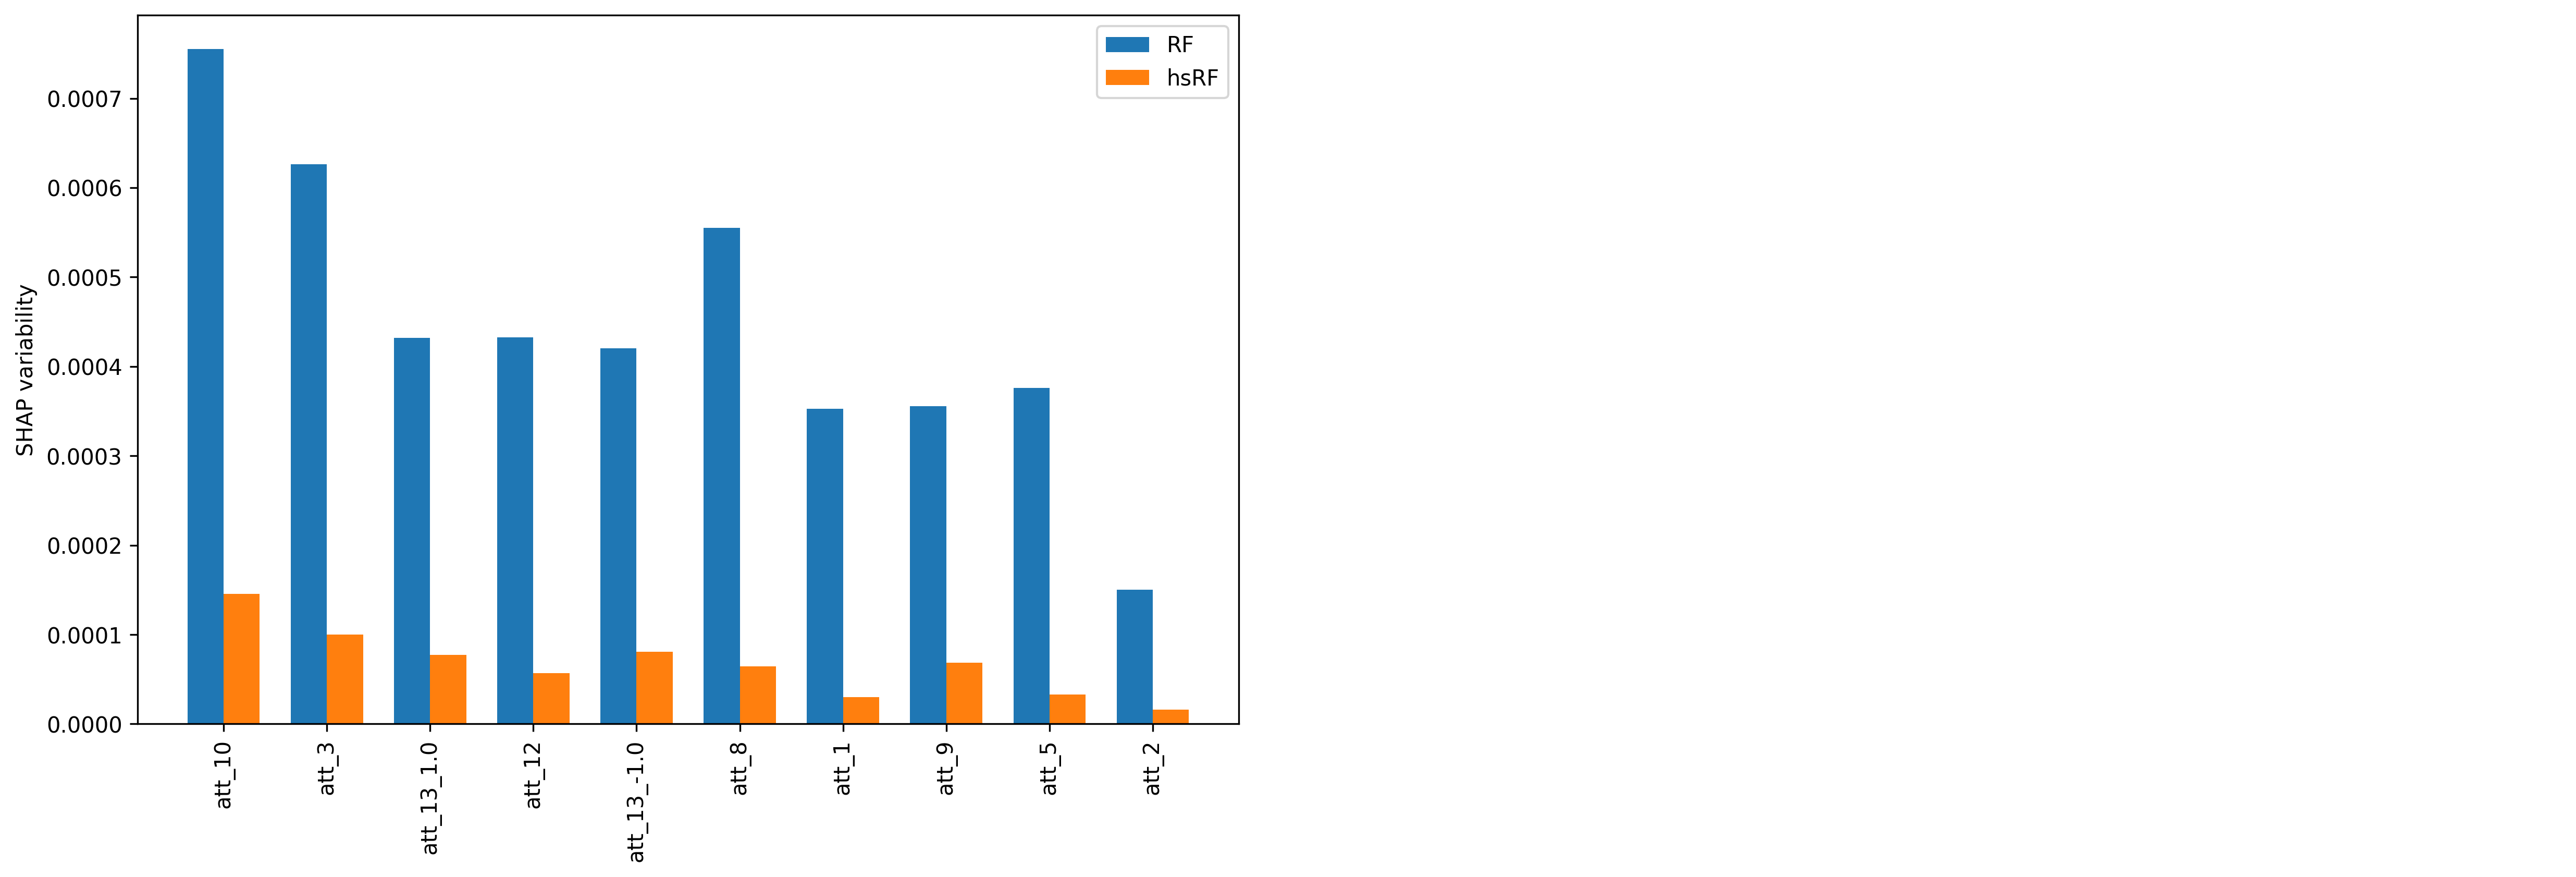

In [29]:
create_shap_variability_plot(shap_avg_var_sk, shap_avg_var_im, feat_names_plot, feat_order)#, 
                             #shap_avg_var_scr, shap_avg_var_scr_HS)